Model Performance and Forecast

--- Step 1: Loading and Cleaning Data ---
Data loaded. Date range: 2019-07-01 to 2024-09-19
--- Step 2: Preparing Features ---
--- Step 3: Evaluating Model (Last 60 Days) ---
Model Performance:
  MAE  (Mean Absolute Error):    1921.65
  RMSE (Root Mean Squared Error):3547.13
  MAPE (Percentage Error):       4.39%
--- Step 4: Generating 365-Day Forecast ---
--- Step 5: Generating Aggregations ---
--- Step 6: Saving Files ---
Saved: Forecast_Daily.csv, Forecast_Weekly.csv, Forecast_Monthly.csv, Forecast_Hourly.csv
--- Step 7: Plotting ---


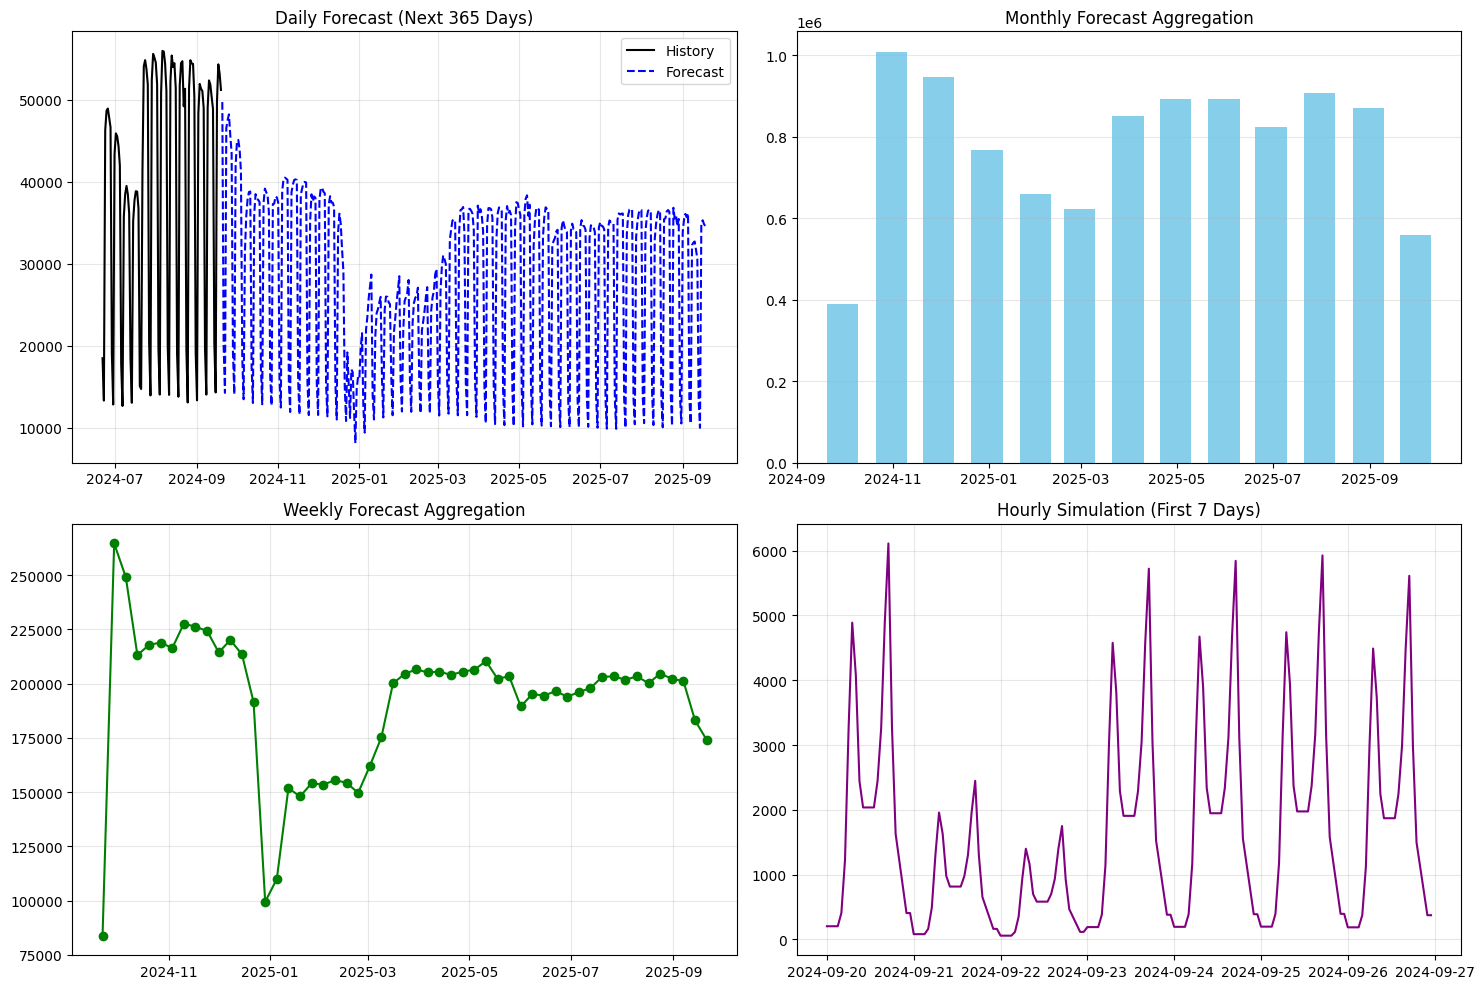

Done.


In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# 1. CONFIGURATION & DATA LOADING
FILE_NAME = 'Daily_Public_Transport_Passenger_Journeys_by_Service_Type_20250603.csv'
CUTOFF_DATE = '2024-09-20' # Critical fix for bad data
FORECAST_DAYS = 365

print("--- Step 1: Loading and Cleaning Data ---")
df = pd.read_csv(FILE_NAME)
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')

# Consolidate Total
df['Other'] = df['Other'].fillna(0)
df['Total'] = df.iloc[:, 1:].sum(axis=1)

# CRITICAL: Filter out incomplete data at the end of the file
df = df[df['Date'] < CUTOFF_DATE].copy()
df = df.sort_values('Date').set_index('Date').asfreq('D')
df['Total'] = df['Total'].interpolate() # Fill small gaps

print(f"Data loaded. Date range: {df.index.min().date()} to {df.index.max().date()}")

# 2. FEATURE ENGINEERING
def create_features(data):
    """Creates Lag and Time features for Random Forest"""
    df_feat = data.copy()
    # Time Features
    df_feat['dayofweek'] = df_feat.index.dayofweek
    df_feat['month'] = df_feat.index.month
    df_feat['dayofyear'] = df_feat.index.dayofyear
    
    # Lag Features (Memory)
    df_feat['lag_1'] = df_feat['Total'].shift(1)
    df_feat['lag_7'] = df_feat['Total'].shift(7)
    df_feat['lag_30'] = df_feat['Total'].shift(30)
    
    # Trend Feature
    df_feat['rolling_mean_7'] = df_feat['Total'].shift(1).rolling(7).mean()
    
    return df_feat.dropna()

print("--- Step 2: Preparing Features ---")
df_ml = create_features(pd.DataFrame(df['Total']))
features = ['dayofweek', 'month', 'dayofyear', 'lag_1', 'lag_7', 'lag_30', 'rolling_mean_7']
target = 'Total'

# 3. MODEL EVALUATION (METRICS)
print("--- Step 3: Evaluating Model (Last 60 Days) ---")
test_days = 60
train = df_ml.iloc[:-test_days]
test = df_ml.iloc[-test_days:]

# Train
rf = RandomForestRegressor(n_estimators=1000, random_state=42)
rf.fit(train[features], train[target])

# Predict
preds = rf.predict(test[features])

# Calculate Metrics
mae = mean_absolute_error(test[target], preds)
rmse = np.sqrt(mean_squared_error(test[target], preds))
mape = np.mean(np.abs((test[target] - preds) / test[target])) * 100

print(f"Model Performance:")
print(f"  MAE  (Mean Absolute Error):    {mae:.2f}")
print(f"  RMSE (Root Mean Squared Error):{rmse:.2f}")
print(f"  MAPE (Percentage Error):       {mape:.2f}%")

# 4. FORECASTING (RECURSIVE LOOP)
print(f"--- Step 4: Generating {FORECAST_DAYS}-Day Forecast ---")

# Retrain on ALL data
rf_full = RandomForestRegressor(n_estimators=1000, random_state=42)
rf_full.fit(df_ml[features], df_ml[target])

# Prepare Loop
last_date = df_ml.index.max()
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=FORECAST_DAYS)
future_predictions = []
history = df['Total'].copy()

# Recursive Loop
for date in future_dates:
    # A. Build Features
    feat_dict = {
        'dayofweek': date.dayofweek,
        'month': date.month,
        'dayofyear': date.dayofyear,
        'lag_1': history.iloc[-1],
        'lag_7': history.iloc[-7],
        'lag_30': history.iloc[-30],
        'rolling_mean_7': history.iloc[-7:].mean()
    }
    
    # B. Predict
    X_input = pd.DataFrame([feat_dict])[features]
    pred_value = rf_full.predict(X_input)[0]
    
    # C. Update History
    future_predictions.append(pred_value)
    history = pd.concat([history, pd.Series([pred_value], index=[date])])

# Create Forecast DataFrame
forecast_df = pd.DataFrame({'Date': future_dates, 'Predicted_Total': future_predictions})
forecast_df.set_index('Date', inplace=True)

# 5. AGGREGATIONS (WEEKLY, MONTHLY, HOURLY)

print("--- Step 5: Generating Aggregations ---")

# A. Monthly
monthly_forecast = forecast_df.resample('ME').sum() # 'ME' is Month End

# B. Weekly
weekly_forecast = forecast_df.resample('W').sum()

# C. Hourly Simulation
# Weights for a typical commuter day (Peaks at 8am and 5pm)
hourly_profile = np.array([
    0.005, 0.005, 0.005, 0.005, 0.01, 0.03, # 00-05
    0.08, 0.12, 0.10, 0.06,                 # 06-09 (Peak)
    0.05, 0.05, 0.05, 0.05, 0.06,           # 10-14
    0.08, 0.12, 0.15, 0.08,                 # 15-18 (Peak)
    0.04, 0.03, 0.02, 0.01, 0.01            # 19-23
])
hourly_profile = hourly_profile / hourly_profile.sum() # Normalize

hourly_data = []
for date, row in forecast_df.iterrows():
    daily_total = row['Predicted_Total']
    for hour in range(24):
        hourly_val = daily_total * hourly_profile[hour]
        timestamp = date + pd.Timedelta(hours=hour)
        hourly_data.append({'Timestamp': timestamp, 'Predicted_Total': hourly_val})

hourly_df = pd.DataFrame(hourly_data)

# 6. SAVING FILES
print("--- Step 6: Saving Files ---")
forecast_df.to_csv('Forecast_Daily.csv')
weekly_forecast.to_csv('Forecast_Weekly.csv')
monthly_forecast.to_csv('Forecast_Monthly.csv')
hourly_df.to_csv('Forecast_Hourly.csv', index=False)

print("Saved: Forecast_Daily.csv, Forecast_Weekly.csv, Forecast_Monthly.csv, Forecast_Hourly.csv")

# 7. VISUALIZATION
print("--- Step 7: Plotting ---")
plt.figure(figsize=(15, 10))

# Daily Plot
plt.subplot(2, 2, 1)
plt.plot(df.index[-90:], df['Total'].iloc[-90:], label='History', color='black')
plt.plot(forecast_df.index, forecast_df['Predicted_Total'], label='Forecast', color='blue', linestyle='--')
plt.title('Daily Forecast (Next 365 Days)')
plt.legend()
plt.grid(True, alpha=0.3)

# Monthly Plot
plt.subplot(2, 2, 2)
plt.bar(monthly_forecast.index, monthly_forecast['Predicted_Total'], width=20, color='skyblue')
plt.title('Monthly Forecast Aggregation')
plt.grid(axis='y', alpha=0.3)

# Weekly Plot
plt.subplot(2, 2, 3)
plt.plot(weekly_forecast.index, weekly_forecast['Predicted_Total'], color='green', marker='o')
plt.title('Weekly Forecast Aggregation')
plt.grid(True, alpha=0.3)

# Hourly Plot (Sample)
plt.subplot(2, 2, 4)
sample = hourly_df.iloc[:24*7] # First week
plt.plot(sample['Timestamp'], sample['Predicted_Total'], color='purple')
plt.title('Hourly Simulation (First 7 Days)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Done.")